In [1]:
# jupyter setup for reloading modules
# %load_ext autoreload
# %autoreload 2


In [149]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
import sqlite3
from paths import PF_DB_PATH, DATA_DIR, AUS_PATH
from IPython.display import Markdown as md
from IPython.display import display
import os

DEBUG = False
PRIMARY_COLOR = "#3891ff"
SECONDARY_COLOR = "#c7cee7"
PALETTE_TWO_COLOR = [SECONDARY_COLOR, PRIMARY_COLOR]
PALETTE_THREE_COLOR = [PRIMARY_COLOR, "#91aef4", SECONDARY_COLOR]
PALETTE_SIX_COLOR = [
    PRIMARY_COLOR,
    "#669cfb",
    "#84a8f6",
    "#9db5f1",
    "#b3c1ec",
    SECONDARY_COLOR,
]


In [3]:
def dist(lat1, lon1, lat2, lon2):
    # calculate distance between two coordinates
    return np.sqrt((lat1 - lat2) ** 2 + (lon1 - lon2) ** 2) * 60 * 1.852


In [4]:
def display_list(lst: list, sep=", ") -> str:
    # join list items to return a merged str for display
    return sep.join(lst)


def debug(df):
    # display df only in debug mode
    # - hide df printout when exporting html
    if DEBUG:
        display(df)


def decluter(
    ax,
    show_spines=False,
    show_xaxis=False,
    show_yaxis=False,
    xlabel=None,
    ylabel=None,
    title=None,
    x_use_million=False,
    x_use_unit=None,
    x_use_int= False,
    y_use_million=False,
    y_use_unit=None,
    y_use_int= False,
    ret_ax =False
):
    # declutter chart by removing unneccessary elements
    # remove spines from chart
    ax.spines["top"].set_visible(show_spines)
    ax.spines["right"].set_visible(show_spines)
    ax.spines["bottom"].set_visible(show_spines)
    ax.spines["left"].set_visible(show_spines)
    # remove x axis
    ax.xaxis.set_visible(show_xaxis)
    # handle x axis labels
    ax.set_xlabel(xlabel)
    # format axis
    if x_use_million:
        ax.xaxis.set_major_formatter(lambda x, pos: f"{x/1e6:.1f}M")
    if x_use_unit:
        ax.xaxis.set_major_formatter(lambda x, pos: f"{x} {x_use_unit}")
    if x_use_int:
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    # remove y axis
    ax.yaxis.set_visible(show_yaxis)
    # handle y axis label
    ax.set_ylabel(ylabel)
    # format axis
    if y_use_million:
        ax.yaxis.set_major_formatter(lambda x, pos: f"{x/1e6:.1f}M")
    if y_use_unit:
        ax.yaxis.set_major_formatter(lambda x, pos: f"{x} {y_use_unit}")
    if y_use_int:
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    # set title
    ax.set_title(title, loc="left")

    # declutter legend
    legend = ax.get_legend()
    if legend:
        legend.get_frame().set_linewidth(0)
        legend.set_title(None)

    if ret_ax:
        return ax


# Introduction

This analysis was done as an overview of properties price trend in Sydney, which would help my family (as new immigrants) to plan for our future purchase. 

First few sections serve as a general understanding of how the overall market behaves over the year, while in the later part of this analysis, focus was gradually shifted towards properties that best suit our needs.

# Dataset
Data source: https://www.pricefinder.com.au/

This dataset was downloaded from PriceFinder as separated `.xlsx` files, which were then merged into a single SQLite database. The SQL database consists of 2 tables:

In [5]:
con = sqlite3.connect(PF_DB_PATH)
raw_records = pd.read_sql_query("SELECT * FROM record", con)
raw_property = pd.read_sql_query("SELECT * FROM property", con)


In [6]:
md(
    f"""
1. records\n
    This table contains {raw_records.shape[0]:,} property sales records, each record contains the following data:
    * `id`: unique identification of the sales record, formed by merging address, postcode and sale date
    * `record_date`: date of sale (from {raw_records.record_date.min()} to {raw_records.record_date.max()})
    * `price`: final sale price
    * `sale_type`: type of sale ({display_list(raw_records.sale_type.unique().tolist())})
    * `prop_id`: id of the property, formed by merging address and postcode
    * `property_type`: type of property ({display_list(raw_records.property_type.unique().tolist())})
    * `bedrooms`: number of bedrooms
    * `bathrooms`: number of bathrooms
    * `carparks`: number of car parks
2. property\n
    This table contains {raw_property.shape[0]:,} properties that have associated sales record(s), each property details consist of the following data:
    * `address`: address with postcode attached, act as unique identification
    * `street`: street name
    * `locality`: suburb name ({raw_property.locality.nunique()} in total)
    * `postcode`: postcode ({raw_property.postcode.nunique()} in total)
    * `land_area`: land area
"""
)



1. records

    This table contains 731,552 property sales records, each record contains the following data:
    * `id`: unique identification of the sales record, formed by merging address, postcode and sale date
    * `record_date`: date of sale (from 2000-01-05 to 2022-01-04)
    * `price`: final sale price
    * `sale_type`: type of sale (Agents Advice - Sale, Normal Sale, Multi-Sale, Part Sale, Unknown)
    * `prop_id`: id of the property, formed by merging address and postcode
    * `property_type`: type of property (Commercial, Unit, Other, House, Vacant Land, Industrial)
    * `bedrooms`: number of bedrooms
    * `bathrooms`: number of bathrooms
    * `carparks`: number of car parks
2. property

    This table contains 455,865 properties that have associated sales record(s), each property details consist of the following data:
    * `address`: address with postcode attached, act as unique identification
    * `street`: street name
    * `locality`: suburb name (844 in total)
    * `postcode`: postcode (312 in total)
    * `land_area`: land area


In [7]:
debug(raw_records.describe(include="all"))
debug(raw_property.describe(include="all"))


# Data Cleaning

In [8]:
# raw dataframe
df_raw = pd.merge(
    raw_records, raw_property, left_on="prop_id", right_on="address", how="left"
).drop(columns=["prop_id"])

# filtered dataframe
last_record_date = "2021-12-31"
df_clean = df_raw.query(
    f"0<=bedrooms<=5 & 0<bathrooms<=5 & 0<=carparks <=3 & price >1000"
)
df_clean = df_clean[df_clean.record_date <= last_record_date]
df_clean["year"] = pd.DatetimeIndex(df_clean.record_date).year


In [9]:
md(
    f"""
There is no missing values in both tables. For `records`, unusually high number of bedrooms, bathrooms and car parks were found, possible due to the sale of buildings as a whole. For normal household, only properties with maximum 5 bedrooms/bathrooms and 3 car parks were considered.

On the other hand, it was noticed that some records show abnormally low prices. These records (specifically, all records with price less than $1,000) were removed from the analysis.

Also, to aid yearly aggregation, a `year` column was generated from `record_date`. It should be noted that only sales records on or before {last_record_date} were considered to ensure accuracy of annual statistics.

Consequently, a combined dataset was then formed by merging the two tables with left join on `records`. The final dataset for analysis consists of {df_clean.shape[0]:,} records ({df_clean.shape[0]/df_raw.shape[0]:.0%} of available records).

"""
)



There is no missing values in both tables. For `records`, unusually high number of bedrooms, bathrooms and car parks were found, possible due to the sale of buildings as a whole. For normal household, only properties with maximum 5 bedrooms/bathrooms and 3 car parks were considered.

On the other hand, it was noticed that some records show abnormally low prices. These records (specifically, all records with price less than $1,000) were removed from the analysis.

Also, to aid yearly aggregation, a `year` column was generated from `record_date`. It should be noted that only sales records on or before 2021-12-31 were considered to ensure accuracy of annual statistics.

Consequently, a combined dataset was then formed by merging the two tables with left join on `records`. The final dataset for analysis consists of 641,588 records (88% of available records).



In [10]:
debug(raw_records.isna().sum())
debug(raw_property.isna().sum())
debug(df_clean.describe(include="all").style.format(dict(price="{:,.0f}")))


Further analysis suggested that most records were `Normal Sales` of either `House` or `Unit` properties. For simplicity and sake of interest, only these records were considered.

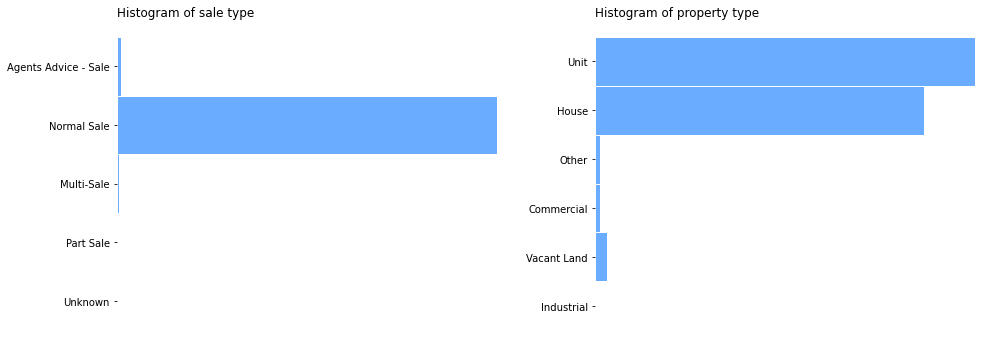

In [66]:
nrow, ncol = 1, 2
fig, axs = plt.subplots(nrow, ncol, figsize=(ncol * 7, nrow * 5))
axs = iter(axs.ravel())

# sale type
ax = next(axs)
sns.histplot(data=df_clean, y="sale_type", ax=ax, color=PRIMARY_COLOR, edgecolor='white')
decluter(ax, show_yaxis=True, title="Histogram of sale type")

# property type
ax = next(axs)
sns.histplot(data=df_clean, y="property_type", ax=ax, color=PRIMARY_COLOR, edgecolor='white')
decluter(ax, show_yaxis=True, title="Histogram of property type")

# fig config
fig.tight_layout()


For sale prices, a small portion of properties were sold in high value. To focus on properties of affordable range, only records with sale price below $3,000,000 were considered.

In [12]:
# filter out selected sale_type and property_type
df_sel = df_clean[
    (df_clean.sale_type == "Normal Sale")
    & (df_clean.property_type.isin(["Unit", "House"]))
]

df = df_sel.query("price <= 3e6")


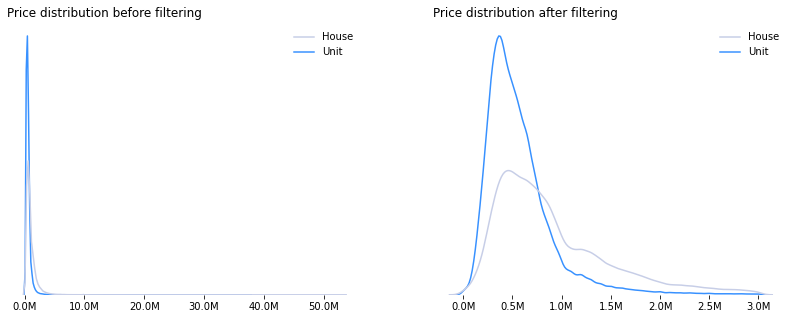

In [39]:
nrow, ncol = 1, 2
fig, axs = plt.subplots(nrow, ncol, figsize=(ncol * 7, nrow * 5))
axs = iter(axs.ravel())


def plot_dist(df, ax, title):
    sns.kdeplot(
        data=df.sort_values('property_type'),
        x="price",
        hue="property_type",
        ax=ax,
        palette= PALETTE_TWO_COLOR
    )
    decluter(ax, title=title, show_xaxis=True, x_use_million=True)


plot_dist(df_sel, next(axs), "Price distribution before filtering")
plot_dist(df, next(axs), "Price distribution after filtering")


In [14]:
debug(df.sale_type.unique())
debug(df.property_type.unique())


In [15]:
# export as csv
df.to_csv(os.path.join(DATA_DIR, "dataset.csv"), index=False)


In summary, the following criterias were applied:

- sales record date: on or before 2021-12-31
- number of bedrooms: 0 to 5
- number of bathrooms: 1 to 5
- number of car parks: 0 to 3
- sale price: $1,000 to $3,000,000

In [16]:
md(
    f"""
The final dataset therefore contains {df.shape[0]:,} records ({df.shape[0]/df_raw.shape[0]:.0%} of the raw data).
"""
)



The final dataset therefore contains 600,451 records (82% of the raw data).


# Analysis

### General price trend

In [17]:
def get_median(df):
    # median by property type and year
    df_med = (
        df.drop(columns=["postcode"])
        .groupby(["property_type", "year"])
        .median()
        .reset_index()
    )
    # add rate of change column
    df_med["price_change"] = df_med.groupby(["property_type"]).price.diff() / df_med.price
    df_med.year = df_med.year.astype(int)
    return df_med
df_med= get_median(df)
debug(df_med.head())


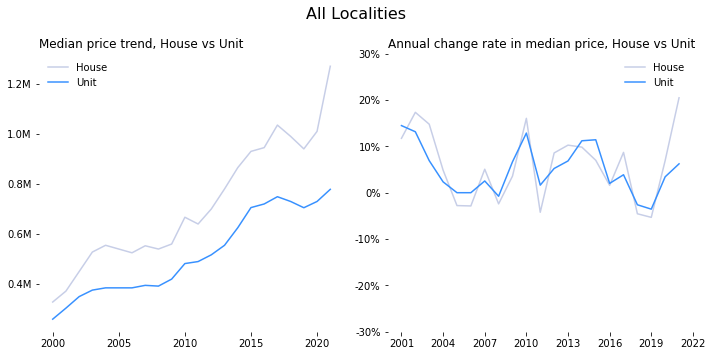

In [18]:
def plot_annual_trend(df, title):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs = iter(axs.ravel())
    ax = next(axs)
    sns.lineplot(
        data=df,
        x="year",
        y="price",
        hue="property_type",
        ax=ax,
        palette=PALETTE_TWO_COLOR,
    )
    decluter(
        ax,
        title="Median price trend, House vs Unit",
        show_xaxis=True,
        show_yaxis=True,
        y_use_million=True,
    )

    ax = next(axs)
    sns.lineplot(
        data=df,
        x="year",
        y="price_change",
        hue="property_type",
        ax=ax,
        palette=PALETTE_TWO_COLOR,
    )
    decluter(
        ax,
        title="Annual change rate in median price, House vs Unit",
        show_xaxis=True,
        show_yaxis=True,
        x_use_int=True,
    )
    ax.yaxis.set_major_formatter(lambda x, pos: f'{x:.0%}')
    ax.set_ylim(-0.3, 0.3)

    fig.tight_layout()
    fig.suptitle(title, size=16)
    fig.subplots_adjust(top=0.85)
    return fig


_ = plot_annual_trend(df_med, "All Localities")


In [19]:
md(f'''
General property price is trending upwards, median annual increment rate (since 2000) being {df_med.query('property_type =="House"').price_change.median():.1%} for Houses and {df_med.query('property_type =="Unit"').price_change.median():.1%} for Units.
''')


General property price is trending upwards, median annual increment rate (since 2000) being 6.9% for Houses and 3.9% for Units.


### Price trend by suburbs

In [20]:
# suburb coordinates
suburb_coord = pd.read_csv(os.path.join(AUS_PATH, "nsw_suburb_coord.csv"))
# calculate distance from CBD
CBD_COORD = (-33.8708, 151.2073)
suburb_coord["cbd_dist"] = suburb_coord.apply(
    lambda row: dist(row["lat"], row["lon"], CBD_COORD[0], CBD_COORD[1]), axis=1
)

# data grouped by suburb
df_sub = (
    df.groupby(["locality", "postcode", "property_type", "year"]).median().reset_index()
)
# merge to get coordinates
df_sub = df_sub.merge(suburb_coord, on="locality")
debug(suburb_coord.head())
debug(df_sub.head())


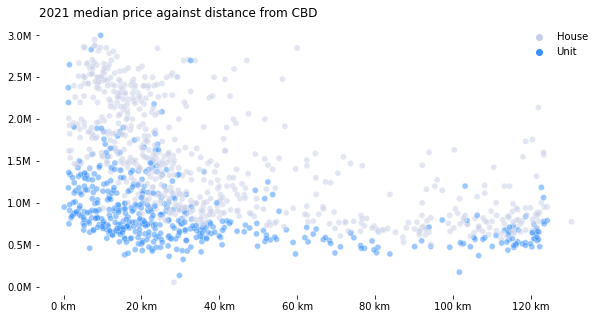

In [21]:
fig, ax = plt.subplots(figsize=(10, 5))
year = 2021
max_dist = 150
sns.scatterplot(
    data=df_sub.query(f"year=={year} & cbd_dist<={max_dist}"),
    x="cbd_dist",
    y="price",
    hue="property_type",
    alpha=0.5,
    ax=ax,
    palette=PALETTE_TWO_COLOR,
)
decluter(
    ax,
    show_xaxis=True,
    show_yaxis=True,
    y_use_million=True,
    title=f"{year} median price against distance from CBD",
)
ax.xaxis.set_major_formatter(lambda x, pos: f'{x:.0f} km')


Median prices of different suburbs were plotted against distance from Sydney CBD. It was observed that property prices for both Houses and Units generally drop off passed 40 km (about 1 hour drive).

In [22]:
bin_edges = [0, 10, 20, 30, 40, 60, 100]
labels = [f"{ed} km" for ed in bin_edges[1:]] + [f"{bin_edges[-1]}+ km"]
df_sub["dist_bin"] = pd.cut(df_sub.cbd_dist, bins=bin_edges + [np.inf], labels=labels)
debug(df_sub.dist_bin.unique())


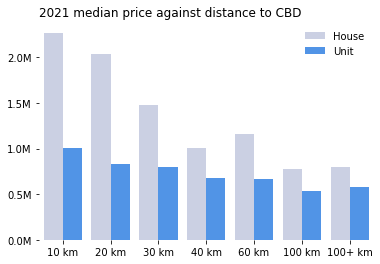

In [23]:
fig, ax = plt.subplots()
year = 2021
sns.barplot(
    data=df_sub.query(f"year=={year}")
    .groupby(["property_type", "dist_bin"])
    .median()
    .reset_index(),
    x="dist_bin",
    y="price",
    ax=ax,
    hue="property_type",
    palette=PALETTE_TWO_COLOR,
)
decluter(
    ax,
    show_yaxis=True,
    show_xaxis=True,
    y_use_million=True,
    title=f"{year} median price against distance to CBD",
)


For 2021, prices for Houses were significantly higher than Units within 30 km from Sydney CBD. Whereas prices for Units appeared to be far less affected by the distance.

In [24]:
CBD_RANGE = 35

md(f'''
### Suburbs closed to CBD
In this section, property sales within {CBD_RANGE} km of Sydney CBD were further analyzed.
''')


### Suburbs closed to CBD
In this section, property sales within 35 km of Sydney CBD were further analyzed.


In [25]:
# list of suburbs within 40km of CBD
cbd_subs= suburb_coord.query(f'cbd_dist<={CBD_RANGE}').locality.tolist()
# data of sales closed to CBD
df_cbd = df[df.locality.isin(cbd_subs)]
# median by property type and year
df_cbd_med = get_median(df_cbd)
debug(df_cbd_med.head())
debug(df_cbd.locality.nunique())

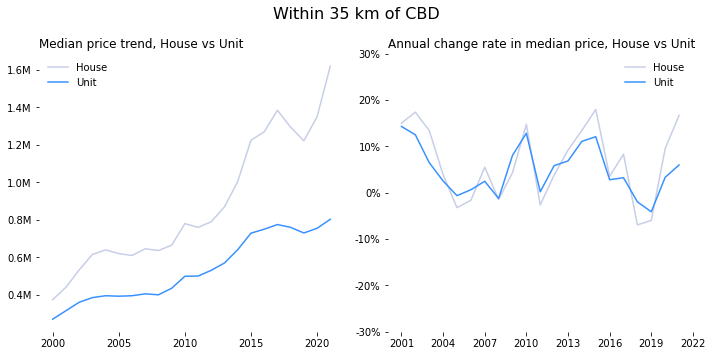

In [26]:
_=plot_annual_trend(df_cbd_med, title=f'Within {CBD_RANGE} km of CBD')

In [27]:
md(f'''
Property price for CBD suburb trends upwards similar to the general market, with median annual increment rate (since 2000) being {df_cbd_med.query('property_type =="House"').price_change.median():.1%} for Houses and {df_cbd_med.query('property_type =="Unit"').price_change.median():.1%} for Units.
''')


Property price for CBD suburb trends upwards similar to the general market, with median annual increment rate (since 2000) being 5.5% for Houses and 3.3% for Units.


##### Annual rate regression
To gauge the price increments on each CBD suburbs, linear regression model was fitted on data of each locality. Assuming that the annual rate of change of price is constant, the price model is therefore:

`log(year) ~ price`

In other words, it is assumed that prices of properties in a suburb increase by a constant percentage every year.

Note that only suburbs with properties sales in at least 9 years from 2000 to 2021 were considered.

In [28]:
# remove localities with too few sale records by year
active_locs = df_cbd.groupby('locality').nunique().query('year >=9').index.tolist()

In [29]:
N_YEAR_THRESHOLD =9

md(f'''
In total, {len(active_locs)} out of {df_cbd.locality.nunique()} CBD suburbs matches this criteria. Note that among these suburbs, in order to obtain sensible results, regression models were fitted only if there are more than {N_YEAR_THRESHOLD} years with sales for each property type (House or Unit). 
''')



In total, 410 out of 436 CBD suburbs matches this criteria. Note that among these suburbs, in order to obtain sensible results, regression models were fitted only if there are more than 9 years with sales for each property type (House or Unit). 


In [30]:
def log_regress(df, n_year_threshold= N_YEAR_THRESHOLD):
    # if number of years wtih sales is fewer than threshold, skip regression
    if df.year.nunique() <n_year_threshold:
        return None
    # model: log(price) ~ year
    model = LinearRegression()
    model.fit(X=np.array(df.year).reshape(-1, 1), y=np.log(df.price))
    results = pd.Series(
        (model.coef_[0], model.intercept_), index=["slope", "intercept"]
    )
    return results


results = df_cbd[df_cbd.locality.isin(active_locs)].groupby(["locality",'property_type']).apply(log_regress)
results['annual_rate']= np.exp(results.slope)-1
debug(results.head())

In [31]:
df_cbd_rates= results.reset_index()
debug(df_cbd_rates)

In [32]:
df_cbd_sub= df_cbd.groupby(['locality','postcode','property_type', 'year']).median().reset_index()
debug(df_cbd_sub)

In [33]:
def fit_price(years, coeffs):
    # return fitted values for given years
    prices = np.exp(years * coeffs["slope"].values + coeffs["intercept"].values)
    df = pd.DataFrame(dict(year=years, price=prices))
    return df


def get_loc_fitted_price(df, coeffs, loc):
    # return df containing fitted price for houses and units of given locality
    prices_house = fit_price(
        df.query("property_type=='House'").year,
        coeffs.query(f"locality=='{loc}' & property_type=='House'"),
    )
    prices_unit = fit_price(
        df.query("property_type=='Unit'").year,
        coeffs.query(f"locality=='{loc}' & property_type=='Unit'"),
    )

    prices = pd.concat(
        [
            pd.DataFrame(
                dict(
                    property_type="House",
                    year=prices_house.year,
                    price=prices_house.price,
                )
            ),
            pd.DataFrame(
                dict(
                    property_type="Unit", year=prices_unit.year, price=prices_unit.price
                )
            ),
        ],
        axis=0,
    )
    return prices


def plot_loc_trend(df_plot, coeffs, ax, loc):
    sns.scatterplot(
        data=df_plot,
        x="year",
        y="price",
        hue="property_type",
        ax=ax,
        palette=PALETTE_TWO_COLOR,
    )
    fitted_prices = get_loc_fitted_price(df_plot, coeffs, loc)
    sns.lineplot(
        data=fitted_prices,
        x="year",
        y="price",
        hue="property_type",
        palette=PALETTE_TWO_COLOR,
        ax=ax,
        linestyle="--",
        legend=False,
    )
    ax.legend(loc='upper left')

    # add label for annual rate
    fp= fitted_prices.set_index(['property_type', 'year'])
    cf= coeffs.set_index(['property_type', 'locality'])

    lab_x = df_plot.query('property_type=="House"').year.max()
    if ('House', loc) in cf.index and ('House', lab_x) in fp.index:
        lab_y= fp.at[('House', lab_x), 'price']
        rate=  cf.at[('House', loc), 'annual_rate']
        if not np.isnan(lab_y) and not np.isnan(rate):
            ax.text(
                lab_x + 0.5,
                lab_y,
                s=f"{rate:.1%}",
                ha="left",
                va="center",
                color=PALETTE_TWO_COLOR[0],
            )

    lab_x = df_plot.query('property_type=="Unit"').year.max()
    if ('Unit', loc) in cf.index and ('Unit', lab_x) in fp.index:
        lab_y= fp.at[('Unit', lab_x), 'price']
        rate=  cf.at[('Unit', loc), 'annual_rate']
        if not np.isnan(lab_y) and not np.isnan(rate):
            ax.text(
                lab_x + 0.5,
                lab_y,
                s=f"{rate:.1%}",
                ha="left",
                va="center",
                color=PALETTE_TWO_COLOR[1],
            )

    # limit axis for comparison
    ax.set_ylim(0, 3e6)
    ax.set_xlim(2000,2022)
    decluter(
        ax,
        show_xaxis=True,
        show_yaxis=True,
        y_use_million=True,
        x_use_int=True,
        title=f"{loc.title()}",
    )


### Suburbs with highest growth rate

With regression applied, suburbs with highest growth rates in both Houses and Units were plotted below as references:

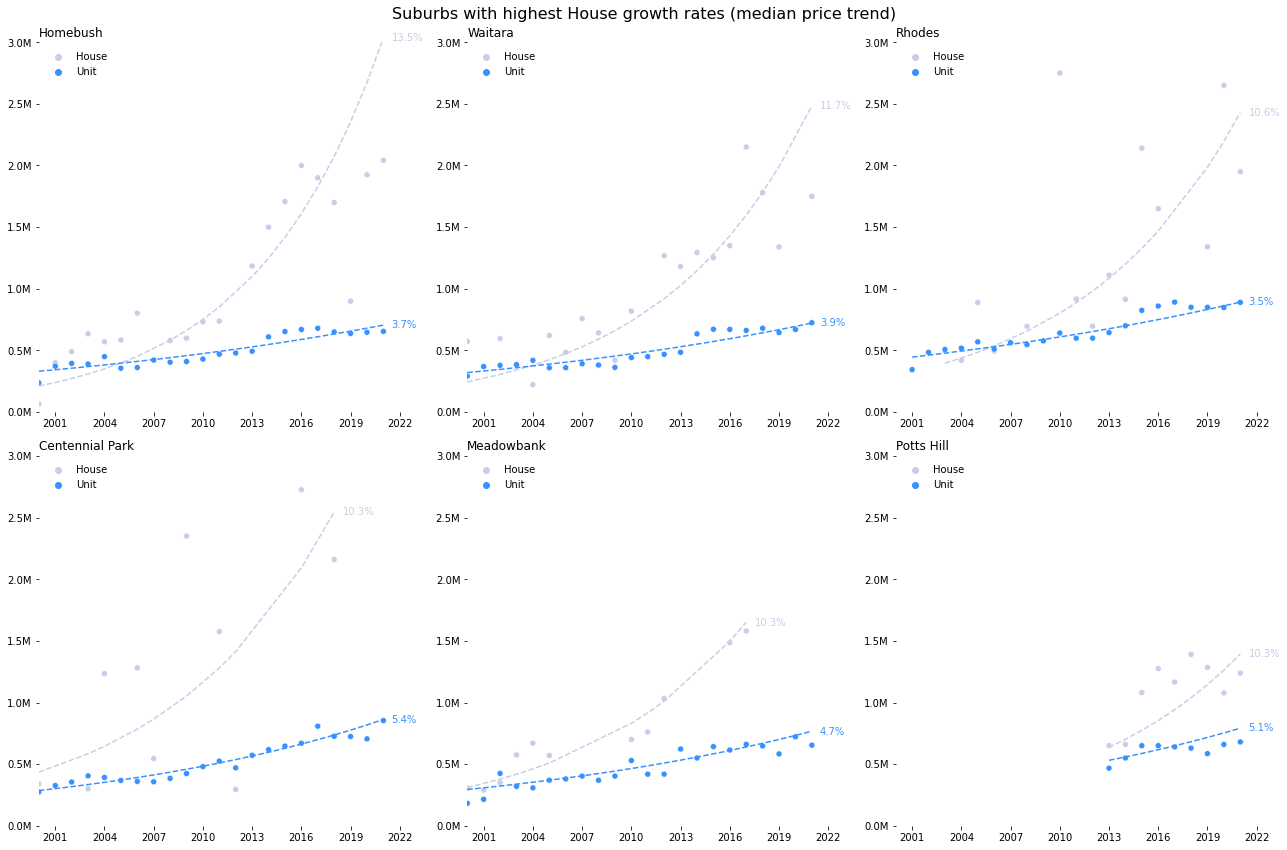

In [112]:
# localities with top House annual rate
fig, axs = plt.subplots(2, 3, figsize=(18, 12))
axs = iter(axs.ravel())

top_house_locs = (
    df_cbd_rates.query('property_type=="House"')
    .sort_values("annual_rate", ascending=False)
    .head(6)
    .locality
)

for loc in top_house_locs:
    ax= next(axs)
    df_plot = df_cbd_sub.query(f"locality=='{loc}'")
    plot_loc_trend(df_plot, df_cbd_rates, ax, loc)

fig.suptitle("Suburbs with highest House growth rates (median price trend)", size=16)
fig.subplots_adjust(top=0.92)
fig.tight_layout()


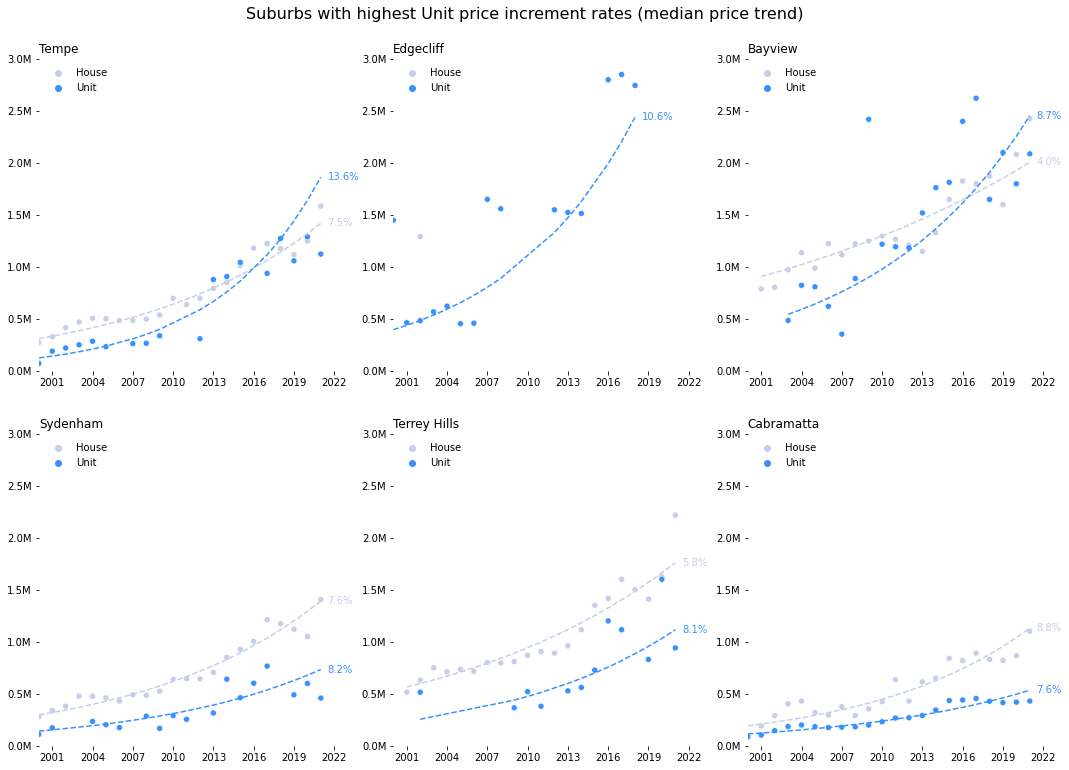

In [40]:
# localities with top Unit annual rate
fig, axs = plt.subplots(2, 3, figsize=(18, 12))
axs = iter(axs.ravel())

top_unit_locs = (
    df_cbd_rates.query('property_type=="Unit"')
    .sort_values("annual_rate", ascending=False)
    .head(6)
    .locality
)

for loc in top_unit_locs:
    ax = next(axs)
    df_plot = df_cbd_sub.query(f"locality=='{loc}'")
    plot_loc_trend(df_plot, df_cbd_rates, ax, loc)

fig.suptitle("Suburbs with highest Unit growth rates (median price trend)", size=16)
fig.subplots_adjust(top=0.92)


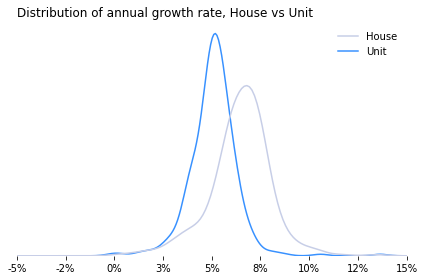

In [63]:
fig, ax = plt.subplots()
sns.kdeplot(data=df_cbd_rates, hue='property_type', x='annual_rate', ax=ax, palette=PALETTE_TWO_COLOR)
ax.set_xlim(-0.05, 0.15)
ax.xaxis.set_major_formatter(lambda x, pos: f"{x:.0%}")
decluter(ax, show_xaxis=True, title= 'Distribution of annual growth rate, House vs Unit')
fig.tight_layout()

In [60]:
house_rate= df_cbd_rates.query('property_type=="House"').annual_rate
unit_rate= df_cbd_rates.query('property_type=="Unit"').annual_rate

md(f'''
In general, growth rate for both Houses and Units are normally distributed. Houses generally see higher growth rate with mean of {house_rate.mean():.1%} and standard deviation of {house_rate.std():.1%}, while that for Units are mean of {unit_rate.mean():.1%} and s.d. of {unit_rate.std():.1%}.
''')


In general, growth rate for both Houses and Units are normally distributed. Houses generally see higher growth rate with mean of 6.4% and standard deviation of 1.8%, while that for Units are mean of 5.1% and s.d. of 1.2%.


### Unit properties, number of bedrooms

In this section, property prices of Units with different number of bedrooms were analyzed. Note that only CBD suburbs were considered.

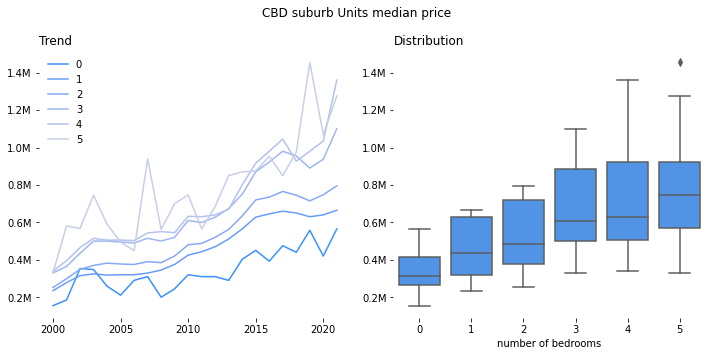

In [166]:
df_unit = df_cbd.query('property_type =="Unit"')
df_unit_med = df_unit.groupby(["bedrooms", "year"]).median().reset_index()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs = iter(axs.ravel())

ax=next(axs)
sns.lineplot(
    data=df_unit_med,
    x="year",
    y="price",
    hue="bedrooms",
    ax=ax,
    palette=PALETTE_SIX_COLOR,
)
decluter(
    ax,
    show_xaxis=True,
    show_yaxis=True,
    y_use_million=True,
    title="Trend",
)

ax=next(axs)
sns.boxplot(data=df_unit_med, x="bedrooms", y="price", ax=ax, color=PRIMARY_COLOR)
decluter(
    ax,
    show_xaxis=True,
    show_yaxis=True,
    y_use_million=True,
    xlabel='number of bedrooms',
    title="Distribution",
)

fig.suptitle('CBD suburb Units median price')
fig.tight_layout()

In general, more bedrooms imply higher median price. For the purpose of family interest, only Units with 1-3 bedrooms were considered in subsequent analysis.

In [167]:
df_unit_sel= df_unit.query('1<= bedrooms <=3')

results= df_unit_sel.groupby(['locality','bedrooms']).apply(log_regress)
results['annual_rate']= np.exp(results.slope)-1
df_unit_rates = results.reset_index()
df_unit_rates

,locality,bedrooms,slope,intercept,annual_rate
0,ABBOTSFORD,1,0.051019,-89.427793,0.052343
1,ABBOTSFORD,2,0.048890,-84.899784,0.050105
2,ABBOTSFORD,3,0.059197,-105.239030,0.060984
3,ALEXANDRIA,1,0.046275,-80.065687,0.047363
4,ALEXANDRIA,2,0.055399,-98.158353,0.056962
...,...,...,...,...,...
1048,YENNORA,2,0.044374,-76.621815,0.045374
1049,YOWIE BAY,3,0.047398,-81.727865,0.048539
1050,ZETLAND,1,0.046657,-80.684980,0.047763
1051,ZETLAND,2,0.045542,-78.147007,0.046595


In [210]:
def plot_loc_trend_bed(df, rates, ax, loc):
    df_plot = df.query(f'locality=="{loc}"')
    years = df_plot.year.unique()
    bedrooms = [1, 2, 3]
    fitted_price = pd.DataFrame()
    rt = rates.set_index(["locality", "bedrooms"])
    for bed in bedrooms:
        if (loc, bed) in rt.index:
            slope = rt.loc[(loc, bed), "slope"]
            inter = rt.loc[(loc, bed), "intercept"]
            fitted_price = pd.concat(
                [
                    fitted_price,
                    pd.DataFrame(
                        dict(year=years, bedrooms=bed, price=np.exp(years * slope + inter))
                    ),
                ]
            )
    palette= {bed:PALETTE_THREE_COLOR[i] for i,bed in enumerate(bedrooms)}
    sns.scatterplot(
        data=df_plot,
        x="year",
        y="price",
        hue="bedrooms",
        ax=ax,
        palette=palette,
    )

    for bed in bedrooms:
        fp= fitted_price.query(f'bedrooms=={bed}').sort_values('year')
        ax.plot(fp.year, fp.price, '--', color= palette[bed])

    ax.legend(loc="upper left")

    # add label for annual rate
    fp = fitted_price.set_index(["bedrooms", "year"])
    rt = rates.set_index(["bedrooms", "locality"])

    lab_x = df_plot.year.max()
    for i, bed in enumerate(bedrooms):
        if (bed, loc) in rt.index and (bed, lab_x) in fp.index:
            lab_y = fp.at[(bed, lab_x), "price"]
            rate = rt.at[(bed, loc), "annual_rate"]
            if not np.isnan(lab_y) and not np.isnan(rate):
                ax.text(
                    lab_x + 0.5,
                    lab_y,
                    s=f"{rate:.1%}",
                    ha="left",
                    va="center",
                    color=PALETTE_THREE_COLOR[i],
                )

    # limit axis for comparison
    ax.set_ylim(0, 3e6)
    ax.set_xlim(2000, 2022)
    decluter(
        ax,
        show_xaxis=True,
        show_yaxis=True,
        y_use_million=True,
        x_use_int=True,
        title=f"{loc.title()}",
    )


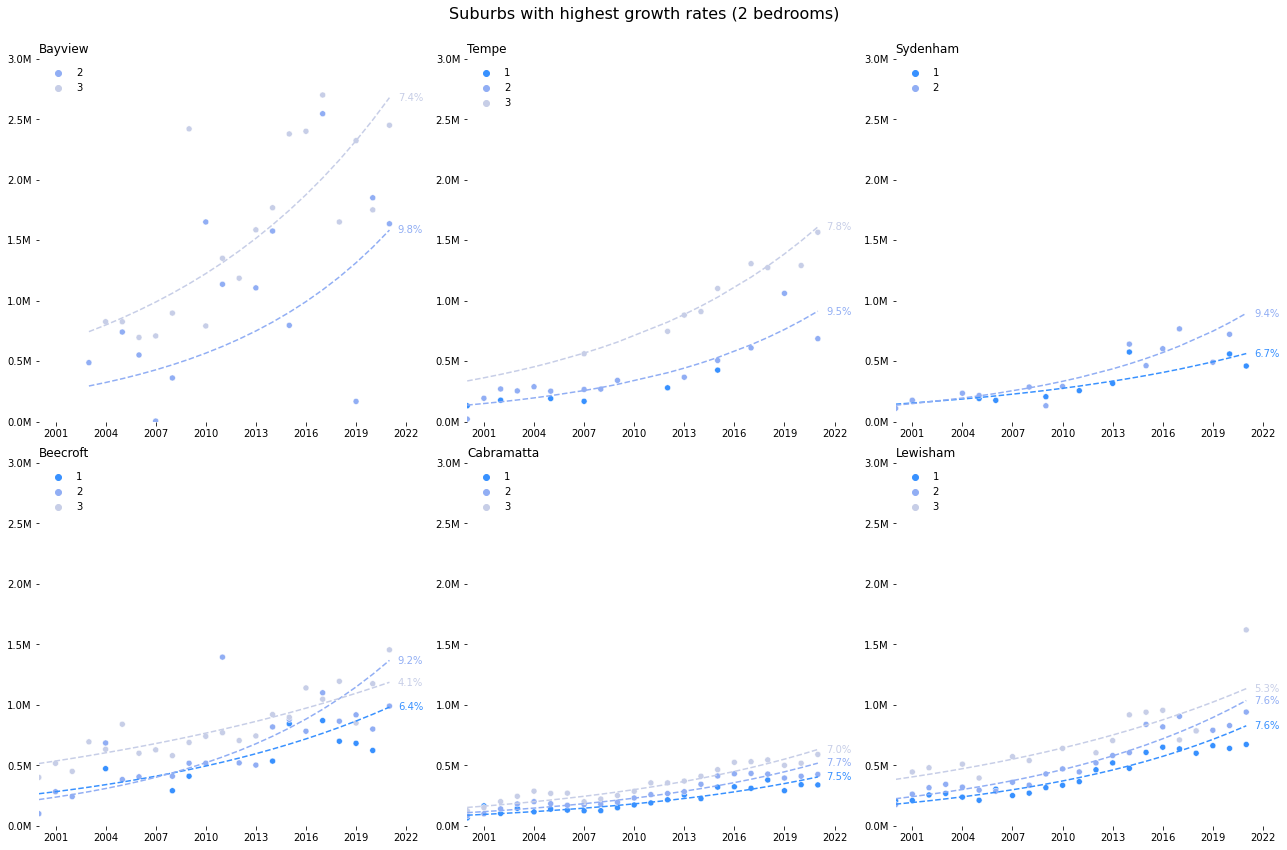

In [215]:
fig, axs = plt.subplots(2, 3, figsize=(18, 12))
axs = iter(axs.ravel())

top_loc_2bed = (
    df_unit_rates.query("bedrooms == 2")
    .sort_values("annual_rate", ascending=False)
    .locality.head(6)
)

df_plot = df_unit_sel.groupby(["locality", "bedrooms", "year"]).median().reset_index()
for loc in top_loc_2bed:
    ax = next(axs)
    plot_loc_trend_bed(df_plot, df_unit_rates, ax, loc)

fig.tight_layout()
fig.suptitle("Suburbs with highest growth rates (2 bedrooms)", size=16)
fig.subplots_adjust(top=0.92)
